# Part 2: Sentiment Classification Model
## Customer Feedback Sentiment Analysis using DistilBERT


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')


d:\Projects\Flikt\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## Load Cleaned Dataset


In [3]:
df = pd.read_csv('cleaned_customer_feedback.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
df.head()


Dataset shape: (259, 18)

Column names: ['Review Title', 'Customer name', 'Rating', 'Rating_Numeric', 'Date', 'Date_Parsed', 'Category', 'Comments', 'Useful', 'Helpful_Count', 'Review_Title_Clean', 'Comments_Clean', 'Combined_Text', 'Review_Title_Processed', 'Comments_Processed', 'Combined_Text_Processed', 'Text_Length', 'Word_Count']


,Review Title,Customer name,Rating,Rating_Numeric,Date,Date_Parsed,Category,Comments,Useful,Helpful_Count,Review_Title_Clean,Comments_Clean,Combined_Text,Review_Title_Processed,Comments_Processed,Combined_Text_Processed,Text_Length,Word_Count
0,Another Midrange killer Smartphone by Xiaomi,Rishikumar Thakur,4.0 out of 5 stars,4.0,on 1 October 2018,2018-10-01,Display,Another Midrange killer Smartphone by Xiaomi\n...,,0,Another Midrange killer Smartphone by Xiaomi,Another Midrange killer Smartphone by Xiaomi M...,Another Midrange killer Smartphone by Xiaomi A...,another midrange killer smartphone xiaomi,another midrange killer smartphone xiaomi majo...,another midrange killer smartphone xiaomi anot...,4579,860
1,vry small size mobile,Raza ji,3.0 out of 5 stars,3.0,on 15 September 2018,2018-09-15,Others,All ok but vry small size mobile,7 people found this helpful,7,vry small size mobile,All ok but vry small size mobile,vry small size mobile All ok but vry small siz...,vry small size mobile,vry small size mobile,vry small size mobile vry small size mobile,54,11
2,Full display not working in all application.,Vaibhav Patel,3.0 out of 5 stars,3.0,on 18 September 2018,2018-09-18,Others,Quite good,7 people found this helpful,7,Full display not working in all application.,Quite good,Full display not working in all application. Q...,full display working application,quite good,full display working application quite good,55,9
3,Value for Money,Amazon Customer,5.0 out of 5 stars,5.0,on 28 September 2018,2018-09-28,Display,Redmi has always have been the the king of bud...,2 people found this helpful,2,Value for Money,Redmi has always have been the the king of bud...,Value for Money Redmi has always have been the...,value money,redmi always king budget segment.and yet anoth...,value money redmi always king budget segment.a...,857,154
4,Not worth for the money,Sudhakaran Wadakkancheri,2.0 out of 5 stars,2.0,on 18 September 2018,2018-09-18,Others,worst product from MI. I am a hardcore fan of ...,6 people found this helpful,6,Not worth for the money,worst product from MI. I am a hardcore fan of ...,Not worth for the money worst product from MI....,worth money,worst product hardcore fan one really disappoi...,worth money worst product hardcore fan one rea...,108,21


## Create Sentiment Labels


In [4]:
def create_sentiment_label(rating):
    if rating >= 4.0:
        return 'Positive'
    elif rating >= 3.0:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Rating_Numeric'].apply(create_sentiment_label)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['Label'] = df['Sentiment'].map(label_map)

print("Sentiment distribution:")
print(df['Sentiment'].value_counts())
print("\nLabel distribution:")
print(df['Label'].value_counts())


Sentiment distribution:
Sentiment
Positive    188
Negative     48
Neutral      23
Name: count, dtype: int64

Label distribution:
Label
2    188
0     48
1     23
Name: count, dtype: int64


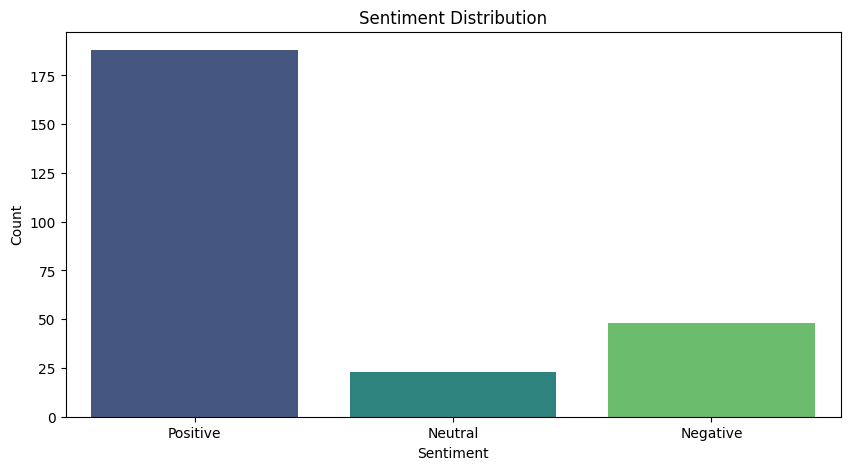

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Prepare Data for Model Training


In [6]:
df_clean = df[['Combined_Text', 'Label']].dropna()
df_clean = df_clean[df_clean['Combined_Text'].str.strip() != '']
df_clean['Combined_Text'] = df_clean['Combined_Text'].astype(str)

print(f"Clean dataset size: {len(df_clean)}")
print(f"Label distribution:")
print(df_clean['Label'].value_counts())


Clean dataset size: 259
Label distribution:
Label
2    188
0     48
1     23
Name: count, dtype: int64


In [7]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_clean['Combined_Text'].tolist(),
    df_clean['Label'].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=df_clean['Label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")


Training samples: 181
Validation samples: 39
Test samples: 39


## Load DistilBERT Tokenizer and Model


In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)
print("Model and tokenizer loaded successfully")


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully


## Tokenize Dataset


In [9]:
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)
test_encodings = tokenize_function(test_texts)

print("Tokenization completed")


Tokenization completed


In [10]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

print("Datasets created successfully")


Datasets created successfully


## Define Training Configuration


In [12]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    use_cpu=True if device.type == 'cpu' else False
)

print("Training configuration set")


Training configuration set


In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Starting model training...")
trainer.train()
print("Training completed!")


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.009700,0.887740,0.743590,0.552926,0.743590,0.634238
2,0.702600,0.575258,0.743590,0.552926,0.743590,0.634238
3,0.533000,0.388587,0.871795,0.813725,0.871795,0.834147


Training completed!


## Model Evaluation


In [15]:
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = test_labels

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("=" * 60)


MODEL EVALUATION RESULTS
Accuracy:  0.8462
Precision: 0.7618
Recall:    0.8462
F1 Score:  0.8007


In [16]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Negative', 'Neutral', 'Positive']))



Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      1.00      0.88         7
     Neutral       0.00      0.00      0.00         4
    Positive       0.87      0.93      0.90        28

    accuracy                           0.85        39
   macro avg       0.55      0.64      0.59        39
weighted avg       0.76      0.85      0.80        39



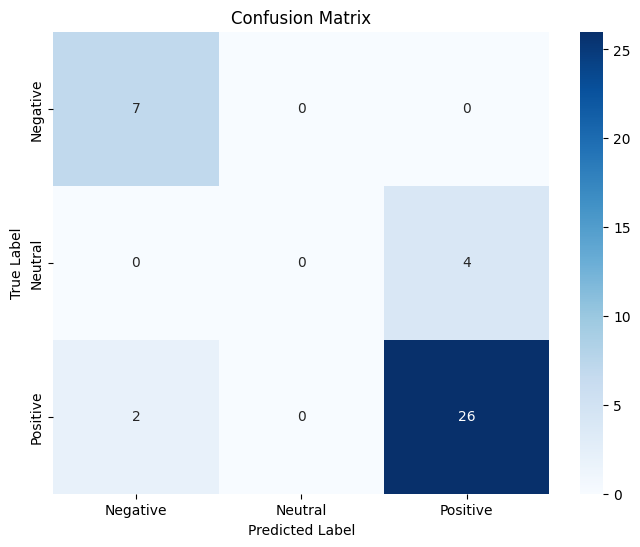

In [17]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Save Model and Tokenizer


In [18]:
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')
print("Model and tokenizer saved successfully to './sentiment_model'")


Model and tokenizer saved successfully to './sentiment_model'


In [19]:
import pickle

model_info = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'label_map': label_map,
    'reverse_label_map': {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
}

with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Model metrics saved to 'sentiment_model.pkl'")


Model metrics saved to 'sentiment_model.pkl'


## Test with Sample Predictions


In [20]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    prediction = torch.argmax(outputs.logits, dim=1).item()
    sentiment = ['Negative', 'Neutral', 'Positive'][prediction]
    confidence = torch.softmax(outputs.logits, dim=1)[0][prediction].item()
    
    return sentiment, confidence

sample_texts = [
    "This phone is absolutely amazing! Best purchase ever!",
    "The product is okay, nothing special",
    "Terrible quality, waste of money. Very disappointed."
]

print("Sample Predictions:")
print("=" * 60)
for text in sample_texts:
    sentiment, confidence = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2%})")
    print("-" * 60)


Sample Predictions:
Text: This phone is absolutely amazing! Best purchase ever!
Predicted Sentiment: Positive (Confidence: 94.66%)
------------------------------------------------------------
Text: The product is okay, nothing special
Predicted Sentiment: Positive (Confidence: 95.05%)
------------------------------------------------------------
Text: Terrible quality, waste of money. Very disappointed.
Predicted Sentiment: Negative (Confidence: 62.15%)
------------------------------------------------------------
